# NETWORK LSTM MODEL MULTIVARIADO - MULTISTEP

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf


In [27]:
df = pd.read_csv('2017-2023_preprocesado.csv', index_col='Timesteps')

In [28]:
df = df.reset_index()
df = df.drop(columns=['Timesteps'])
df

,Unnamed: 0,bx_gsm,by_gsm,bz_gsm,bt,Kp
0,0,-4.384540,0.151482,-2.747153,5.864738,3.333
1,1,-2.083439,-0.208964,-2.461775,5.662317,3.667
2,2,-1.154902,0.917093,-1.160736,4.204290,2.667
3,3,-0.272552,-0.552822,-0.523117,4.356062,2.333
4,4,1.430231,2.103350,-0.312276,4.290185,2.333
...,...,...,...,...,...,...
13918,13918,-1.010831,2.140212,4.917626,5.530442,1.667
13919,13919,-0.821487,2.506119,4.728662,5.517849,1.333
13920,13920,-1.122956,3.178282,4.084596,5.360607,2.000
13921,13921,0.477437,2.309392,-2.623546,4.183323,2.000


In [29]:
df= df.drop(columns=['Unnamed: 0'])

In [30]:
df

,bx_gsm,by_gsm,bz_gsm,bt,Kp
0,-4.384540,0.151482,-2.747153,5.864738,3.333
1,-2.083439,-0.208964,-2.461775,5.662317,3.667
2,-1.154902,0.917093,-1.160736,4.204290,2.667
3,-0.272552,-0.552822,-0.523117,4.356062,2.333
4,1.430231,2.103350,-0.312276,4.290185,2.333
...,...,...,...,...,...
13918,-1.010831,2.140212,4.917626,5.530442,1.667
13919,-0.821487,2.506119,4.728662,5.517849,1.333
13920,-1.122956,3.178282,4.084596,5.360607,2.000
13921,0.477437,2.309392,-2.623546,4.183323,2.000


In [31]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (11138, 5)
Tamaño set de validación: (1392, 5)
Tamaño set de prueba: (1393, 5)


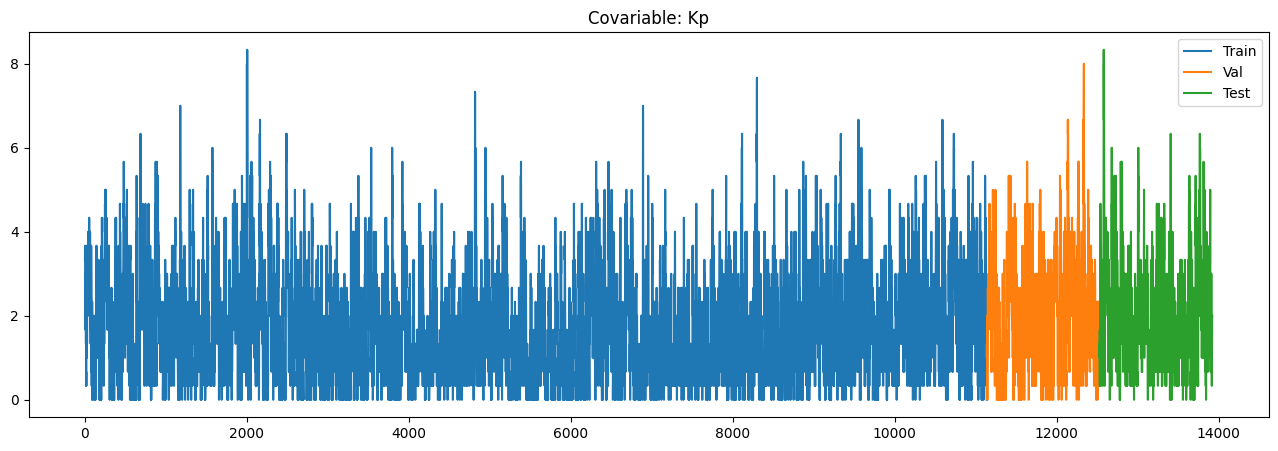

In [32]:
covar = 4 # Índice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

In [33]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [50]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 8  # Hiperparámetro
OUTPUT_LENGTH = 8    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (11122, 8, 5), y_tr: (11122, 8, 1)
Set de validación - x_vl: (1376, 8, 5), y_vl: (1376, 8, 1)
Set de prueba - x_ts: (1377, 8, 5), y_ts: (1377, 8, 1)


In [51]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [52]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'Kp' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

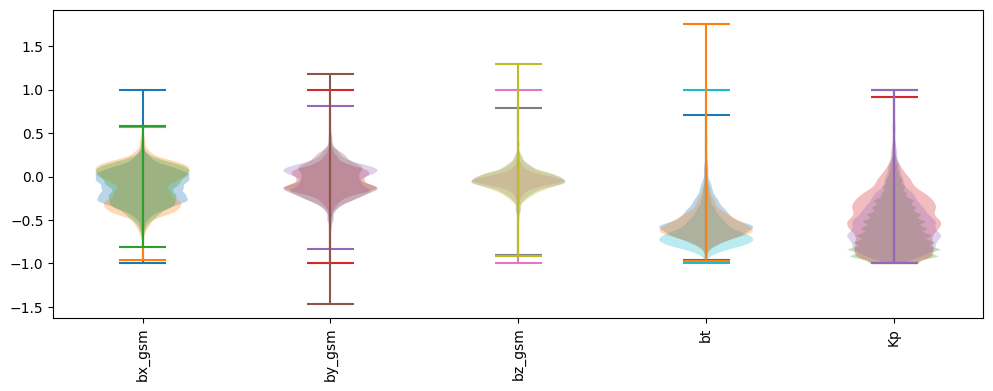

In [53]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(5):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(5)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

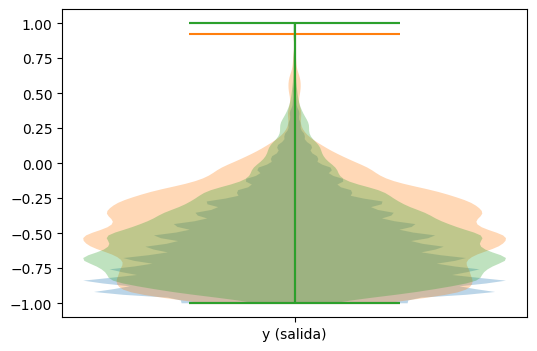

In [54]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

In [55]:
# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS =  128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 13 (features)

modelo = Sequential([
    LSTM(N_UNITS, input_shape=INPUT_SHAPE),
    Dense(64, activation='linear'),
    
    Dense(OUTPUT_LENGTH, activation='linear')
])

# el tamaño deldato de salida (24 horas)

# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)
modelo.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               68608     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 77,384
Trainable params: 77,384
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 64 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100
174/174 - 3s - loss: 0.4134 - val_loss: 0.2941 - 3s/epoch - 16ms/step
Epoch 2/100
174/174 - 1s - loss: 0.2722 - val_loss: 0.2884 - 1s/epoch - 6ms/step
Epoch 3/100
174/174 - 1s - loss: 0.2689 - val_loss: 0.2843 - 1s/epoch - 6ms/step
Epoch 4/100
174/174 - 1s - loss: 0.2663 - val_loss: 0.2819 - 1s/epoch - 6ms/step
Epoch 5/100
174/174 - 1s - loss: 0.2644 - val_loss: 0.2790 - 1s/epoch - 6ms/step
Epoch 6/100
174/174 - 1s - loss: 0.2626 - val_loss: 0.2780 - 1s/epoch - 6ms/step
Epoch 7/100
174/174 - 1s - loss: 0.2612 - val_loss: 0.2756 - 1s/epoch - 6ms/step
Epoch 8/100
174/174 - 1s - loss: 0.2599 - val_loss: 0.2743 - 1s/epoch - 6ms/step
Epoch 9/100
174/174 - 1s - loss: 0.2588 - val_loss: 0.2722 - 1s/epoch - 6ms/step
Epoch 10/100
174/174 - 1s - loss: 0.2576 - val_loss: 0.2718 - 1s/epoch - 6ms/step
Epoch 11/100
174/174 - 1s - loss: 0.2568 - val_loss: 0.2731 - 1s/epoch - 6ms/step
Epoch 12/100
174/174 - 1s - loss: 0.2562 - val_loss: 0.2686 - 1s/epoch - 6ms/step
Epoch 13/100
174/174 - 1

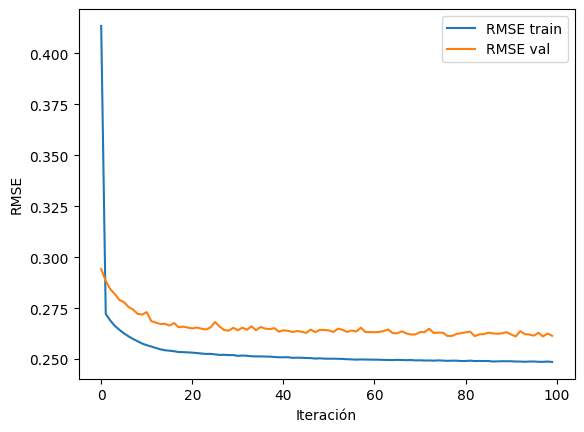

In [57]:
# Graficar curvas de entrenamiento y validación
# para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

In [58]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.241
  RMSE val:	 0.260
  RMSE test:	 0.255


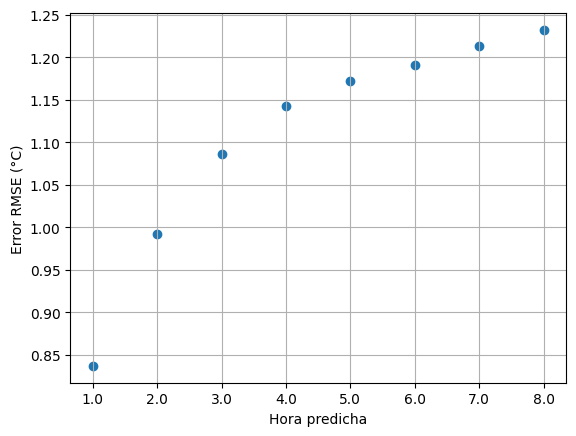

In [60]:
# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Realizar la transformación inversa de las predicciones para llevar sus
# valores a la escala original
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 3. Calcular RMSE para cada instante de tiempo predicho
diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # BATCHESx4
proms = np.mean(diff_cuad, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4

# Graficar rmse para cada timestep
t = np.linspace(1,8,8)

fig, ax = plt.subplots()
ax.scatter(t,rmse)
ax.set_xlabel('Hora predicha')
ax.set_ylabel('Error RMSE (°C)')
plt.xticks(ticks=t, labels=t)
plt.grid();

In [65]:
proms

array([0.70059039, 0.9843516 , 1.17934474, 1.30454777, 1.37355705,
       1.41728851, 1.47184494, 1.51797947])

In [67]:
modelo.save("lstm_modelo.h5")